In [1]:
import os
import sys
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.preprocessing import MinMaxScaler

eradir = Path(os.path.expanduser('~/ERA5/'))                                                                  

In [2]:
#da = xr.open_dataarray(eradir / 'olr_tropics.nc')
#da = xr.open_dataset(eradir / 'sst_nhplus.nc', group = 'mean')['sst-mean']
da = xr.open_dataarray(eradir / 'sst_nhplus.nc')

regions = pd.DataFrame({'latrange':[slice(-1.5,5.5),slice(10.75,15.25),slice(19.5,24.25)],
    'lonrange':[slice(162,169),slice(147,151.75),slice(155,161)]},
    index = pd.Index(['warm1','cold1','cold2']), dtype = 'object')

def selectregion(array: xr.DataArray, name: str):
    assert (name in regions.index), f'choose one of the region names in {regions.index}'
    return array.sel(latitude = regions.loc[name,'latrange'], longitude = regions.loc[name,'lonrange'])

def spatial_mean(array: xr.DataArray):
    stacked = array.stack({'latlon':['latitude','longitude']})
    return stacked.mean('latlon')

def annual_mean(array: xr.DataArray):
    return array.groupby(array.time.dt.year).mean()

In [3]:
warm = selectregion(da,'warm1')
cold1 = selectregion(da,'cold1')
cold2 = selectregion(da,'cold2')

### Calculate & visualize the index

In [4]:
index = spatial_mean(warm) - np.stack([spatial_mean(cold1),spatial_mean(cold2)]).min(axis = 0)
index2 = spatial_mean(warm) - np.stack([spatial_mean(cold1),spatial_mean(cold2)]).mean(axis = 0)

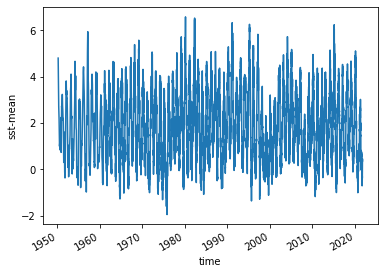

In [7]:
index.plot()

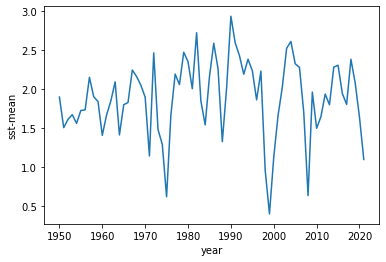

In [8]:
index.groupby(index.time.dt.year).mean().plot()

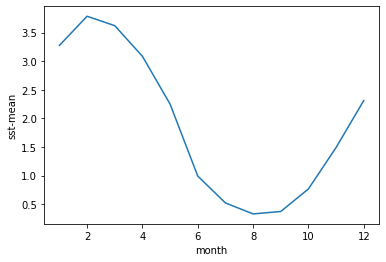

In [9]:
index.groupby(index.time.dt.month).mean().plot()

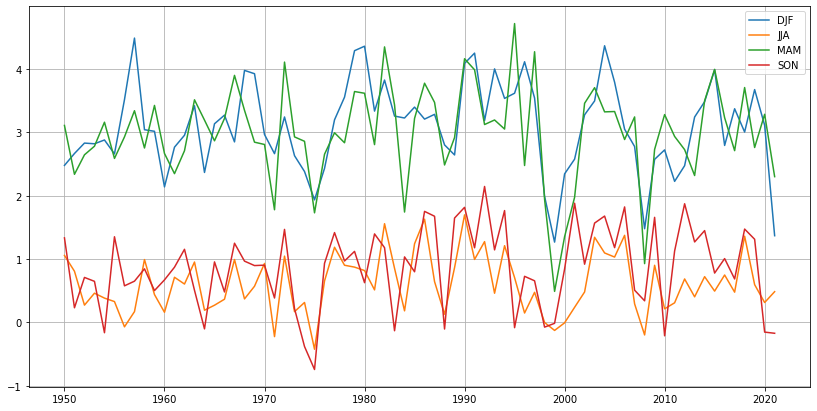

In [30]:
fig, ax = plt.subplots(figsize = (14,7))

for season in np.unique(index.time.dt.season):
    s = index.loc[index.time.dt.season == season]
    yearly = s.groupby(s.time.dt.year).mean()
    ax.plot(yearly.year, yearly.values, label = season)
ax.legend()
ax.grid(True)

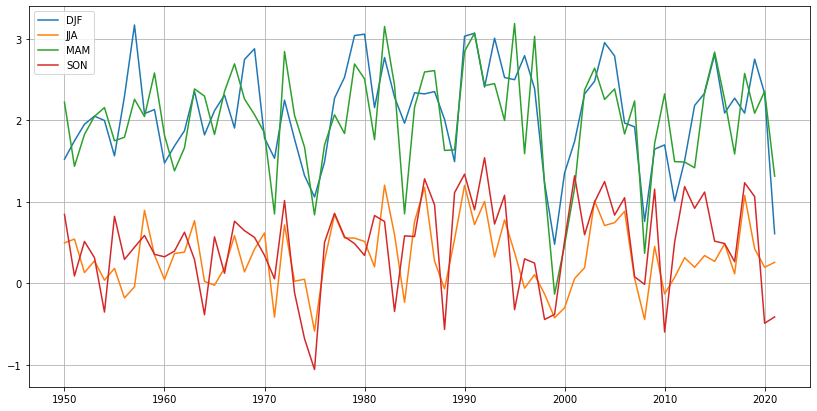

In [32]:
fig, ax = plt.subplots(figsize = (14,7))

for season in np.unique(index2.time.dt.season):
    s = index2.loc[index2.time.dt.season == season]
    yearly = s.groupby(s.time.dt.year).mean()
    ax.plot(yearly.year, yearly.values, label = season)
ax.legend()
ax.grid(True)

### Detrending, de-seasonalizing.

In [34]:
# Third order polynomial?, if per year then discontinuities?
#X = warm.coords['time'].to_index().to_julian_date()
def fit_poly(array, degree: int = 3, year: int = None) -> xr.DataArray:
    """
    Fit 3rd order seasonal polynomial for each gridpoint in this data. 
    X is day of the year.
    Possibly for a single year, otherwise all years are joined
    returns array of coefficients.
    """
    if not (year is None):
        array = array.sel(time = (warm.time.dt.year == year))
    X = array.coords['time'].dt.dayofyear
    y = array.stack({'latlon':['latitude','longitude']})
    coefs = np.polynomial.polynomial.polyfit(x = X, y = y, deg = degree)
    coefs = xr.DataArray(coefs, dims = ('coefs','latlon'), coords = y.coords['latlon'].coords)
    coefs = coefs.assign_coords({'coefs':np.arange(degree+1)})
    return coefs.unstack('latlon')

def evaluate_poly(array : xr.DataArray, coefs: xr.DataArray, year: int = None):
    """
    Evaluates the polynomial on the first time dimension. np.Polyval cannot do this for all gridcells at once
    So custom computation.
    """
    if not (year is None):
        array = array.sel(time = (warm.time.dt.year == year))
    X = array.coords['time'].dt.dayofyear
    y = xr.DataArray(np.zeros(array.shape), coords = array.coords, dims = array.dims)
    for degree in range(len(coefs)): # possibly later: https://en.wikipedia.org/wiki/Horner%27s_method
        y += X**degree * coefs.sel(coefs = degree, drop = True)
    return y

def deseasonalize(array: xr.DataArray, per_year: bool = False, return_polyval: bool = False, degree = 3):
    """
    If per year then trend is removed (and likely also interannual variability)
    plus you'll get a jump on the first of january. (not so important for summer)
    """
    deseasonalized = array.copy()
    if per_year:
        years = np.unique(array.time.dt.year)
        if return_polyval:
            polyval = array.copy()
        for year in years:
            yearly_polyval = evaluate_poly(array, coefs = fit_poly(array, year = year, degree = degree), year = year)
            deseasonalized.loc[deseasonalized.time.dt.year == year,...] = deseasonalized.loc[deseasonalized.time.dt.year == year,...] - yearly_polyval
            polyval.loc[polyval.time.dt.year == year,...] = yearly_polyval
    else:
        polyval = evaluate_poly(array, coefs = fit_poly(array, degree = degree))
        deseasonalized -= polyval
    if return_polyval:
        return deseasonalized, polyval
    else:
        return deseasonalized

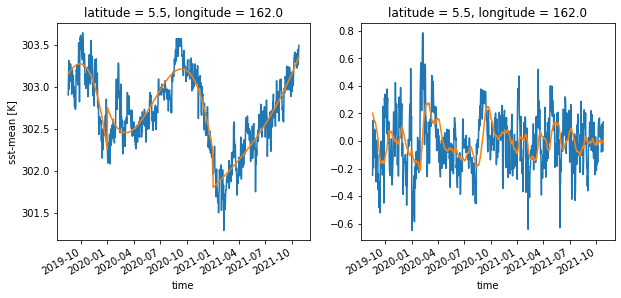

In [40]:
start = -800
latidx = -1
lonidx = 0
detrended, polyval = deseasonalize(warm,per_year=True, return_polyval=True)
fig, axes = plt.subplots(ncols = 2, figsize = (10,4))
warm[start:,latidx,lonidx].plot(ax = axes[0])
polyval[start:,latidx,lonidx].plot(ax = axes[0])
detrended[start:,latidx,lonidx].plot(ax = axes[1])
detrended[:,latidx,lonidx].rolling({'time':31}).mean()[start:].plot(ax = axes[1])

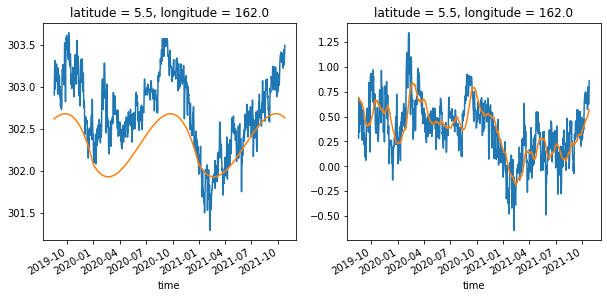

In [39]:
detrended, polyval = deseasonalize(warm,per_year=False, return_polyval=True, degree = 3)
fig, axes = plt.subplots(ncols = 2, figsize = (10,4))
warm[start:,latidx,lonidx].plot(ax = axes[0])
polyval[start:,latidx,lonidx].plot(ax = axes[0])
detrended[start:,latidx,lonidx].plot(ax = axes[1])
detrended[:,latidx,lonidx].rolling({'time':31}).mean()[start:].plot(ax = axes[1])

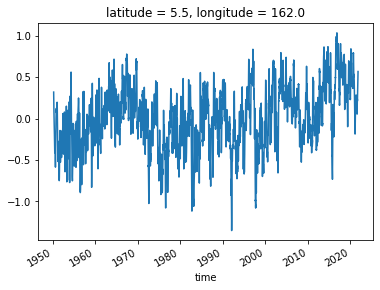

In [38]:
detrended[:,latidx,lonidx].rolling({'time':31}).mean().plot()

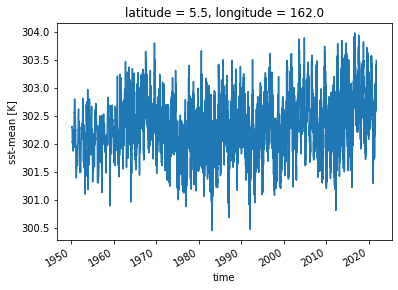

In [26]:
warm[:,latidx,lonidx].plot()

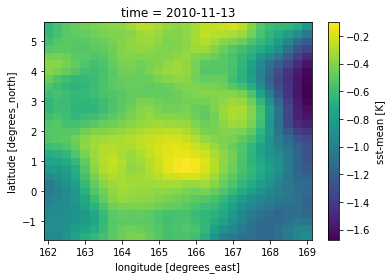

In [33]:
detrended[-000,:,:].plot()